In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from scipy.stats import spearmanr
import os


In [50]:
# ===============================================================
# COACH CHANGE PREDICTION — DATA PREPARATION
# ===============================================================


# ===============================================================
# Load Data
# ===============================================================
coaches = pd.read_csv("data/coaches.csv")
teams = pd.read_csv("data/teams.csv")

# ===============================================================
# Basic Cleaning and Derived Metrics
# ===============================================================
# Compute win ratio
coaches["win_ratio"] = coaches["won"] / (coaches["won"] + coaches["lost"])
coaches = coaches.sort_values(["tmID", "year"]).reset_index(drop=True)

# ===============================================================
# Add info about next year's coach (target variable)
# ===============================================================
coaches["next_coachID"] = coaches.groupby("tmID")["coachID"].shift(-1)
coaches["coach_changed_next_year"] = (coaches["coachID"] != coaches["next_coachID"]).astype(int)

# ===============================================================
# Add team context (ranking and playoff info)
# ===============================================================
teams_subset = teams[["year", "tmID", "rank", "playoff", "won", "lost"]]
coach_teams = pd.merge(coaches, teams_subset, on=["year", "tmID"], how="left")

# ===============================================================
# Compute change vs previous year
# ===============================================================
coach_teams = coach_teams.sort_values(["tmID", "year"]).reset_index(drop=True)

coach_teams["prev_win_ratio"] = coach_teams.groupby("tmID")["win_ratio"].shift(1)
coach_teams["prev_rank"] = coach_teams.groupby("tmID")["rank"].shift(1)
coach_teams["prev_playoff"] = coach_teams.groupby("tmID")["playoff"].shift(1)

# Performance change features
coach_teams["win_ratio_change"] = coach_teams["win_ratio"] - coach_teams["prev_win_ratio"]
coach_teams["rank_change"] = coach_teams["prev_rank"] - coach_teams["rank"]  # positive = improved rank
coach_teams["playoff_miss"] = ((coach_teams["prev_playoff"] == "Y") & (coach_teams["playoff"] == "N")).astype(int)

# ===============================================================
# Drop invalid / incomplete rows
# ===============================================================
coach_teams = coach_teams.dropna(subset=["win_ratio", "prev_win_ratio"])

# ===============================================================
# Keep useful columns only
# ===============================================================
final_cols = [
    "year", "tmID", "coachID", "win_ratio", "prev_win_ratio", "win_ratio_change",
    "rank", "prev_rank", "rank_change", "playoff", "prev_playoff", "playoff_miss",
    "coach_changed_next_year"
]
coach_model_df = coach_teams[final_cols]

# ===============================================================
# 8️⃣ Save prepared dataset
# ===============================================================
os.makedirs("data_models", exist_ok=True)
coach_model_df.to_csv("data_models/coach_firing_dataset.csv", index=False)

print("✅ Dataset ready: data_models/coach_firing_dataset.csv")
print(f"Shape: {coach_model_df.shape}")
print(coach_model_df.head(10))


✅ Dataset ready: data_models/coach_firing_dataset.csv
Shape: (142, 13)
    year tmID     coachID  win_ratio  prev_win_ratio  win_ratio_change  rank  \
1     10  ATL  meadoma99w   0.529412        0.117647          0.411765     2   
3      2  CHA  donovan99w   0.562500        0.250000          0.312500     4   
4      3  CHA  donovan99w   0.562500        0.562500          0.000000     2   
5      4  CHA  laceytr99w   0.529412        0.562500         -0.033088     2   
6      5  CHA  laceytr99w   0.470588        0.529412         -0.058824     5   
7      6  CHA  boguemu01w   0.300000        0.470588         -0.170588     6   
8      6  CHA  laceytr99w   0.125000        0.300000         -0.175000     6   
9      7  CHA  boguemu01w   0.323529        0.125000          0.198529     6   
11     8  CHI  overtbo99w   0.411765        0.147059          0.264706     6   
12     9  CHI   keyst99wc   0.352941        0.411765         -0.058824     5   

    prev_rank  rank_change playoff prev_playoff 

Treino: (98, 13) | Teste (8): (14, 13)

📊 Evaluation for year 8:
Accuracy:  0.714
Precision: 0.625
Recall:    0.833
F1-score:  0.714
ROC–AUC:   0.667

🏀 Top predicted coach changes:
     year tmID     coachID  win_ratio  win_ratio_change  rank  pred_proba  \
137     8  WAS  adubari99w   0.000000         -0.529412     5    0.725731   
37      8  HOU  thompka99w   0.382353         -0.147059     5    0.662470   
70      8  MIN  zierddo99w   0.294118         -0.097187     6    0.614548   
80      8  NYL  coylepa99w   0.470588          0.147059     4    0.545659   
124     8  SEA  donovan99w   0.500000         -0.029412     4    0.510020   
8       8  CHI  overtbo99w   0.411765          0.264706     6    0.509389   
138     8  WAS  rollitr01w   0.533333          0.533333     5    0.386237   
45      8  IND  wintebr01w   0.617647          0.000000     2    0.352996   
57      8  LAS  coopemi01w   0.294118         -0.441176     7    0.323461   
93      8  PHO  westhpa99w   0.676471          0

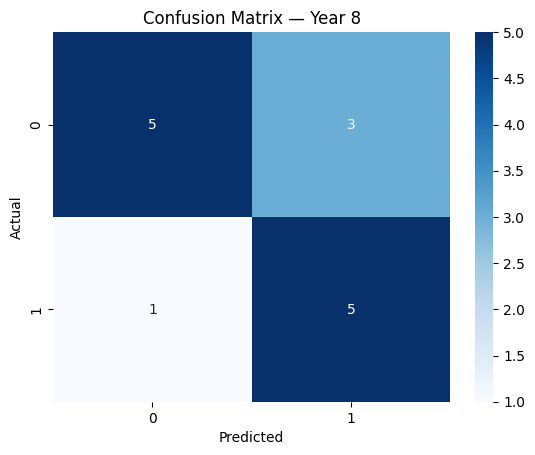

/tmp/ipykernel_4717/78554093.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")


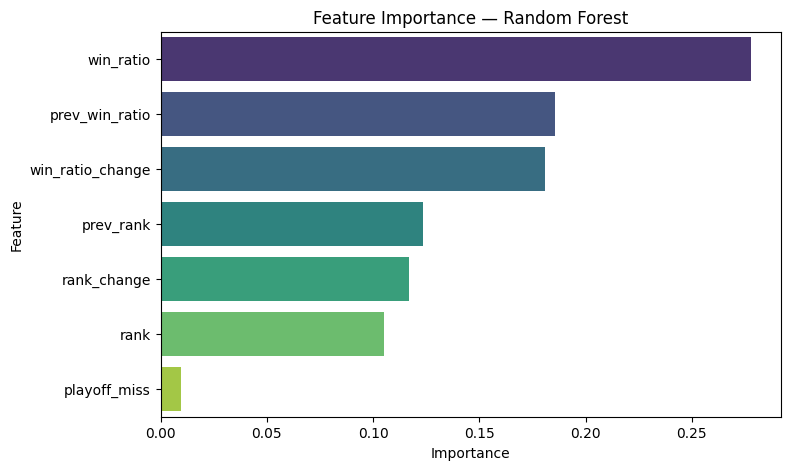


💡 Feature Influence (higher = more impact on firing prediction):
            Feature  Importance
0         win_ratio    0.277961
1    prev_win_ratio    0.185550
2  win_ratio_change    0.181090
4         prev_rank    0.123515
5       rank_change    0.117119
3              rank    0.104973
6      playoff_miss    0.009792

✅ Results saved to: data_models/predictions_model2.csv


In [53]:
# ===============================================================
# COACH CHANGE PREDICTION — MODEL & EVALUATION
# ===============================================================

# ===============================================================
# Load prepared dataset
# ===============================================================
coach_df = pd.read_csv("data_models/coach_firing_dataset.csv")

# ===============================================================
# Choose target year
# ===============================================================

target_year = 8  # Change this as needed
train_data = coach_df[coach_df["year"] < target_year]
test_data  = coach_df[coach_df["year"] == target_year]

print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")

# ===============================================================
# Define features and target
# ===============================================================
features = [
    "win_ratio", "prev_win_ratio", "win_ratio_change",
    "rank", "prev_rank", "rank_change", "playoff_miss"
]
target = "coach_changed_next_year"

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)

# ===============================================================
# Predictions
# ===============================================================


test_data = test_data.copy()
test_data.loc[:, "pred_proba"] = model.predict_proba(X_test)[:, 1]

threshold = 0.35
test_data.loc[:, "predicted_change"] = (test_data["pred_proba"] > threshold).astype(int)


# ===============================================================
# Evaluation
# ===============================================================
acc = accuracy_score(y_test, test_data["predicted_change"])
prec = precision_score(y_test, test_data["predicted_change"])
rec = recall_score(y_test, test_data["predicted_change"])
f1 = f1_score(y_test, test_data["predicted_change"])
roc = roc_auc_score(y_test, test_data["pred_proba"])

print(f"\n📊 Evaluation for year {target_year}:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC–AUC:   {roc:.3f}")

# ===============================================================
# Display predictions
# ===============================================================
print("\n🏀 Top predicted coach changes:")
print(
    test_data[[
        "year", "tmID", "coachID", "win_ratio", "win_ratio_change",
        "rank", "pred_proba", "predicted_change"
    ]]
    .sort_values("pred_proba", ascending=False)
    .head(10)
)

# ===============================================================
# Confusion Matrix
# ===============================================================

# Column [0]: probability of class 0 → coach stays

# Column [1]: probability of class 1 → coach changes/fired


cm = confusion_matrix(y_test, test_data["predicted_change"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — Year {target_year}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ===============================================================
# Feature Importance
# ===============================================================

importance = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance — Random Forest")
plt.show()

print("\n💡 Feature Influence (higher = more impact on firing prediction):")
print(importance)

# ===============================================================
# Save predictions
# ===============================================================
os.makedirs("data_models", exist_ok=True)
test_data.to_csv("data_models/predictions_model2.csv", index=False)
print("\n✅ Results saved to: data_models/predictions_model2.csv")


   year  accuracy        f1   roc_auc
0     3  0.315789  0.133333  0.446429
1     4  0.642857  0.615385  0.770833
2     5  0.411765  0.285714  0.347222
3     6  0.733333  0.666667  0.660000
4     7  0.571429  0.250000  0.479167
5     8  0.571429  0.400000  0.645833
6     9  0.928571  0.888889  1.000000
7    10  0.500000  0.666667       NaN


/home/pjoca/Secretária/Universidade/4ºano/1ºsemestre/AC/ac-data-mining-project/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


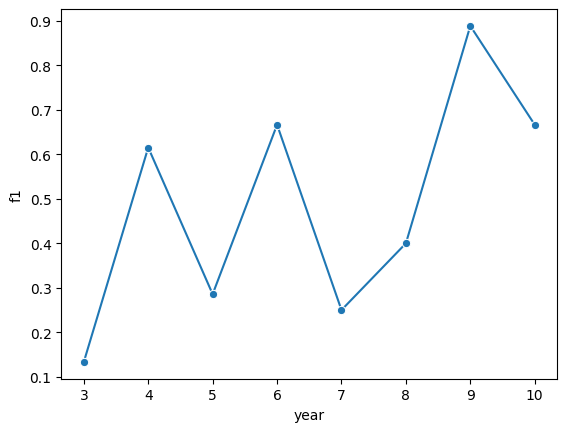

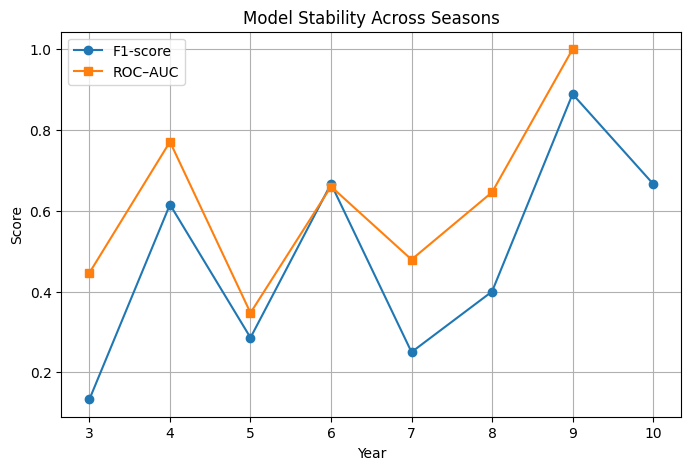

In [52]:
results = []
for yr in sorted(coach_df["year"].unique()):
    train = coach_df[coach_df["year"] < yr]
    test = coach_df[coach_df["year"] == yr]
    if len(test) < 5 or len(train) < 10:  # skip tiny folds
        continue

    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    results.append({
        "year": yr,
        "accuracy": accuracy_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, proba)
    })

results_df = pd.DataFrame(results)
print(results_df)
sns.lineplot(data=results_df, x="year", y="f1", marker="o")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(results_df["year"], results_df["f1"], marker="o", label="F1-score")
plt.plot(results_df["year"], results_df["roc_auc"], marker="s", label="ROC–AUC")
plt.xlabel("Year")
plt.ylabel("Score")
plt.title("Model Stability Across Seasons")
plt.legend()
plt.grid(True)
plt.show()

